# OpenDV Demo (DINO-Foresight)

Segmentation-only visualization for OpenDV clips using the DINO-Foresight model.
Update paths in the config cell before running.

In [124]:
import argparse
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import base64
import io
import json
import uuid

import einops
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from IPython.display import HTML, display
from PIL import Image


def denormalize_images(tensor):
    """Denormalize ImageNet-normalized tensor [B,T,C,H,W] -> [0,1]."""
    mean = torch.tensor([0.485, 0.456, 0.406], device=tensor.device).view(1, 1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=tensor.device).view(1, 1, 3, 1, 1)
    denorm = tensor * std + mean
    return torch.clamp(denorm, 0, 1)


OBJ_COLORS_DICT = {
    0: [128, 64, 128],
    1: [244, 35, 232],
    2: [70, 70, 70],
    3: [102, 102, 156],
    4: [190, 153, 153],
    5: [153, 153, 153],
    6: [250, 170, 30],
    7: [220, 220, 0],
    8: [107, 142, 35],
    9: [152, 251, 152],
    10: [70, 130, 180],
    11: [220, 20, 60],
    12: [255, 0, 0],
    13: [0, 0, 142],
    14: [0, 0, 70],
    15: [0, 60, 100],
    16: [0, 80, 100],
    17: [0, 0, 230],
    18: [119, 11, 32],
}
CLASS_COLORS = np.array(list(OBJ_COLORS_DICT.values()), dtype=np.uint8)


def labels_to_color(labels, color_map):
    labels = labels.clip(0, len(color_map) - 1)
    return Image.fromarray(color_map[labels])

In [125]:
def display_segm_grid(
    seeds,
    context_rgbs,
    context_segs,
    sample_segs,
    base_duration=83,
    scale=0.75,
    cell_width=None,
    cell_height=None,
    context_label="RGB (Context)",
    pred_label="Segm (Pred)",
    pred_is_mask=True,
):
    unique_id = uuid.uuid4().hex
    container_id = f"container_{unique_id}"

    ref_w, ref_h = 256, 256
    if context_rgbs:
        ref_w, ref_h = context_rgbs[0].width, context_rgbs[0].height
    elif sample_segs and sample_segs[0]:
        ref_w, ref_h = sample_segs[0][0].width, sample_segs[0][0].height

    final_w = cell_width if cell_width is not None else ref_w
    final_h = cell_height if cell_height is not None else ref_h
    base_px_w = int(final_w * scale)
    base_px_h = int(final_h * scale)

    animation_data = {}

    def process_frames(frames, is_mask=False):
        if not frames:
            return []
        b64_list = []
        fmt = "PNG" if is_mask else "JPEG"
        for img in frames:
            if img.width != base_px_w or img.height != base_px_h:
                img = img.resize((base_px_w, base_px_h))
            buffer = io.BytesIO()
            if fmt == "JPEG":
                img.convert("RGB").save(buffer, format="JPEG", quality=85)
            else:
                img.save(buffer, format="PNG")
            b64_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
            b64_list.append(f"data:image/{fmt.lower()};base64,{b64_str}")
        return b64_list

    css_w_var = f"--grid-w-{unique_id}"
    css_h_var = f"--grid-h-{unique_id}"
    style_dim = f"width: var({css_w_var}); height: var({css_h_var});"
    style_w_only = f"width: var({css_w_var}); min-width: var({css_w_var});"

    def get_anim_cell_html(frames, is_mask=False):
        if not frames:
            return ""
        cell_id = f"anim_{unique_id}_{uuid.uuid4().hex}"
        processed = process_frames(frames, is_mask)
        animation_data[cell_id] = processed
        first_frame = processed[0] if processed else ""
        return (
            f"<img id='{cell_id}' src='{first_frame}' "
            f"style='{style_dim} object-fit: contain; display:block; margin:0; padding:0;' />"
        )

    bg_color = "#333333"
    text_color = "#ffffff"
    accent_color = "#4db8ff"
    border_color = "#444444"
    separator_style = f"border-right: 1px solid {border_color};"

    fn_speed = f"setSpeed_{unique_id}"
    fn_scale = f"setScale_{unique_id}"

    rows_config = [
        (context_label, context_rgbs, [[] for _ in seeds], False),
        (pred_label, context_segs, sample_segs, pred_is_mask),
    ]

    def make_btn(fn_name, group_name, value, label, is_default=False):
        weight = "bold" if is_default else "normal"
        return (
            f"<button class='btn-{group_name}-{unique_id}' "
            f"onclick='{fn_name}({value}, this)' "
            f"style='cursor:pointer; padding: 2px 8px; font-weight:{weight}; "
            f"background: #444; color: #fff; border: 1px solid #555; margin-right: 2px;'>"
            f"{label}</button>"
        )

    html = f"""
    <div id="{container_id}"
         style="font-family: sans-serif; background-color: {bg_color}; padding: 10px;
                border: 1px solid {border_color}; width: fit-content;
                {css_w_var}: {base_px_w}px;
                {css_h_var}: {base_px_h}px;">
        <div style="margin-bottom: 10px; display: flex; flex-wrap: wrap; align-items: center; gap: 15px;
                    color: {text_color}; font-size: 13px;">
            <div style="display:flex; align-items:center; gap:5px;">
                <span style="font-weight:bold; color: {accent_color};">SPEED:</span>
                {make_btn(fn_speed, "speed", 4.0, "0.25x")}
                {make_btn(fn_speed, "speed", 1.0, "1x", True)}
                {make_btn(fn_speed, "speed", 0.5, "2x")}
            </div>
            <div style="display:flex; align-items:center; gap:5px; padding-left: 10px; border-left: 1px solid #555;">
                <span style="font-weight:bold; color: {accent_color};">SCALE:</span>
                {make_btn(fn_scale, "scale", 0.5, "0.5x")}
                {make_btn(fn_scale, "scale", 1.0, "1x", True)}
                {make_btn(fn_scale, "scale", 1.5, "1.5x")}
            </div>
            <span id="fps_display_{unique_id}"
                  style="margin-left:auto; color: #888; font-size: 12px;">{int(1000/base_duration)} FPS</span>
        </div>

        <div style="overflow-x: auto;">
        <table style="border-collapse: collapse; border-spacing: 0; margin: 0; padding: 0;
                      background-color: {bg_color}; border: 1px solid {border_color};">
            <thead>
                <tr>
                    <th style="background-color: {bg_color}; border: 1px solid {border_color};"></th>
                    <th style="padding: 10px 0; color: {accent_color}; font-weight: bold; font-size: 14px;
                               background-color: {bg_color}; border: 1px solid {border_color};
                               {separator_style} {style_w_only} text-align: center;">
                        CONTEXT
                    </th>
                    <th colspan="{len(seeds)}"
                        style="padding: 10px; color: {accent_color}; font-weight: bold; font-size: 14px;
                               background-color: {bg_color}; border: 1px solid {border_color}; text-align: center;">
                        SAMPLED FUTURES
                    </th>
                </tr>
                <tr>
                    <th style="background-color: {bg_color}; border: 1px solid {border_color};"></th>
                    <th style="background-color: {bg_color}; border: 1px solid {border_color}; {separator_style}"></th>
    """

    for seed in seeds:
        html += f"""
            <th style="padding: 5px 0; color: {text_color}; font-size: 12px; font-weight: normal;
                       background-color: {bg_color}; border: 1px solid {border_color};
                       {style_w_only} text-align: center;">
                seed={seed}
            </th>
        """
    html += "</tr></thead><tbody>"

    for label, ctx_frames, sample_list, is_mask in rows_config:
        html += "<tr>"
        html += (
            f"<td style='padding: 10px; font-weight: bold; text-align: center; color: {text_color};"
            f"                       background-color: {bg_color}; border: 1px solid {border_color}; vertical-align: middle;'>"
            f"{label}</td>"
        )
        html += (
            f"<td style='padding: 0; margin: 0; line-height: 0; border: 1px solid {border_color};"
            f"                       {separator_style} {style_w_only}'>"
            f"{get_anim_cell_html(ctx_frames, is_mask)}"
            f"</td>"
        )
        for i, _ in enumerate(seeds):
            frames = sample_list[i] if i < len(sample_list) else []
            html += (
                f"<td style='padding: 0; margin: 0; line-height: 0; border: 1px solid {border_color};"
                f"                           {style_w_only}'>"
                f"{get_anim_cell_html(frames, is_mask)}"
                f"</td>"
            )
        html += "</tr>"

    html += "</tbody></table></div></div>"

    json_data = json.dumps(animation_data)
    js_script = f"""
    <script>
    (function() {{
        const animData = {json_data};
        const baseDuration = {base_duration};
        const uniqueId = "{unique_id}";
        const baseW = {base_px_w};
        const baseH = {base_px_h};
        const containerId = "{container_id}";
        let timer = null;
        let currentFrameIdx = 0;

        function startLoop(multiplier) {{
            if (timer) clearInterval(timer);
            const interval = baseDuration * multiplier;
            const disp = document.getElementById('fps_display_' + uniqueId);
            if (disp) disp.innerText = (Math.round(1000 / interval * 10) / 10) + " FPS";
            timer = setInterval(() => {{
                currentFrameIdx++;
                for (const [id, frames] of Object.entries(animData)) {{
                    const imgEl = document.getElementById(id);
                    if (imgEl && frames.length > 0) {{
                        imgEl.src = frames[currentFrameIdx % frames.length];
                    }}
                }}
            }}, interval);
        }}

        function setActiveBtn(btnElement, className) {{
            if (btnElement) {{
                const allBtns = document.getElementsByClassName(className);
                for (let i = 0; i < allBtns.length; i++) {{
                    allBtns[i].style.fontWeight = "normal";
                    allBtns[i].style.background = "#444";
                }}
                btnElement.style.fontWeight = "bold";
                btnElement.style.background = "#666";
            }}
        }}

        window["{fn_speed}"] = function(multiplier, btnElement) {{
            startLoop(multiplier);
            setActiveBtn(btnElement, "btn-speed-" + uniqueId);
        }};

        window["{fn_scale}"] = function(scaleMult, btnElement) {{
            const newW = Math.floor(baseW * scaleMult);
            const newH = Math.floor(baseH * scaleMult);
            const container = document.getElementById(containerId);
            container.style.setProperty("--grid-w-" + uniqueId, newW + "px");
            container.style.setProperty("--grid-h-" + uniqueId, newH + "px");
            setActiveBtn(btnElement, "btn-scale-" + uniqueId);
        }};

        startLoop(1.0);
    }})();
    </script>
    """
    display(HTML(html + js_script))


In [126]:
args = argparse.Namespace()
# Data / OpenDV config
args.data_path = '/mnt/hdd1/pengyu/OpenDV-YouTube'  # base root or full_images/val_images
args.opendv_root = args.data_path
args.opendv_train_root = None
args.opendv_val_root = None
args.opendv_meta_path = None
args.opendv_lang_root = None
args.opendv_use_lang_annos = False
args.opendv_filter_folder = None
args.opendv_max_clips = None
args.opendv_video_dir = None  # set to a specific video dir if desired
args.opendv_return_language = False
args.opendv_lang_cache_path = None
args.opendv_lang_cache_train = None
args.opendv_lang_cache_val = None
args.opendv_feat_ext = '.dinov2.pt'
args.opendv_use_lang_features = False
args.opendv_lang_feat_name = 'lang_clip_{start}_{end}.pt'
args.opendv_lang_feat_key = 'text_tokens'
args.opendv_lang_mask_key = 'attention_mask'

args.sequence_length = 5
args.batch_size = 1
args.img_size = (196, 392)
args.num_workers = 2
args.num_workers_val = None
args.random_crop = False
args.random_horizontal_flip = False
args.random_time_flip = False
args.timestep_augm = None
args.no_timestep_augm = False
args.ddp_stage_log_path = None
args.use_val_to_train = False
args.use_train_to_val = False
args.dataloader_timeout = 0
args.dataloader_log_path = None
args.dataloader_log_every = 0
args.eval_mode = True
args.eval_midterm = False
args.eval_modality = None

# Model / head config (match your checkpoint)
args.feature_extractor = 'dino'
args.dinov2_variant = 'vitb14_reg'
args.d_layers = [5, 11]
args.hidden_dim = 768
args.heads = 8
args.layers = 8
args.dropout = 0.1
args.loss_type = 'SmoothL1'
args.beta_smoothl1 = 0.1
args.attn_dropout = 0.3
args.step = 1
args.masking = 'simple_replace'
args.train_mask_mode = 'full_mask'
args.seperable_attention = True
args.seperable_window_size = 1
args.train_mask_frames = 1
args.single_step_sample_train = True
args.output_activation = 'none'
args.use_first_last = False
args.down_up_sample = False
args.pca_ckpt = None
args.crop_feats = False
args.sliding_window_inference = False
args.high_res_adapt = False
args.use_fc_bias = True
args.use_bn = True
args.use_cls = False
args.nfeats = 256
args.dpt_out_channels = [128, 256, 512, 512]
args.num_classes = 19
args.head_ckpt = None

args.use_language_condition = True
args.use_precomputed_text = True
args.use_precomputed_feats = False
args.clip_model_name = 'openai/clip-vit-base-patch32'
args.clip_max_length = 77
args.clip_cache_dir = None
args.clip_local_files_only = False
args.clip_text_dim = 512

args.vis_attn = False

args.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [127]:
from src.data import OpenDV_VideoData, opendv_collate, process_trainmode, IMAGE_EXTS
from src.dino_f import Dino_f
import os
import os.path as osp

ckpt_path = '/home/ruofei/pengyu/DINO-Foresight/dino-foresight/u7fvr3vo/checkpoints/last.ckpt'

data = OpenDV_VideoData(arguments=args, subset='val', batch_size=args.batch_size)
dataset = data._dataset("val", eval_mode=False)

if getattr(dataset, "use_annotations", False):
    clip = dataset.clips[int(np.random.randint(len(dataset.clips)))]
    frames_filepaths = dataset._clip_frame_paths(clip, min_frames=dataset._min_frames_required())
else:
    video_dir = dataset.video_dirs[int(np.random.randint(len(dataset.video_dirs)))]
    frames_filepaths = sorted(
        [
            osp.join(video_dir, name)
            for name in os.listdir(video_dir)
            if name.lower().endswith(IMAGE_EXTS)
        ]
    )

frames = process_trainmode(
    frames_filepaths,
    args.img_size,
    subset="train",
    augmentations=dataset.augmentations,
    sequence_length=args.sequence_length,
    feature_extractor=args.feature_extractor,
)

batch = opendv_collate([frames])

model = Dino_f.load_from_checkpoint(ckpt_path, args=args, strict=False).to(args.device)
model.eval()
model._init_feature_extractor()
if model.dino_v2 is not None:
    model.dino_v2 = model.dino_v2.to(args.device)
if model.eva2clip is not None:
    model.eva2clip = model.eva2clip.to(args.device)
if model.sam is not None:
    model.sam = model.sam.to(args.device)

if isinstance(batch, (list, tuple)):
    frames = batch[0]
    gt_img = batch[1] if len(batch) > 1 else None
else:
    frames = batch
    gt_img = None

frames = frames.to(args.device)
denorm = denormalize_images(frames).cpu()
context_len = max(0, frames.shape[1] - 1)
to_pil = T.ToPILImage()
context_rgbs = [to_pil(denorm[0, i]) for i in range(context_len)]


Using cache found in /home/ruofei/.cache/torch/hub/facebookresearch_dinov2_main


In [128]:
def decode_segm_from_feats(feats, model, out_size):
    b, h, w, _ = feats.shape
    pred_list = [
        feats[:, :, :, i * model.feature_dim:(i + 1) * model.feature_dim]
        for i in range(model.d_num_layers)
    ]
    pred_list = [
        einops.rearrange(x, 'b h w c -> b (h w) c', h=h, w=w)
        for x in pred_list
    ]
    segm_logits = model.head(pred_list, h, w)
    segm_logits = F.interpolate(segm_logits, size=out_size, mode='bilinear', align_corners=False)
    segm_labels = torch.argmax(segm_logits, dim=1)
    return segm_labels


def rollout_segmentation(model, frames, unroll_steps=8):
    preds = []
    with torch.no_grad():
        x = model.preprocess(frames)
        for _ in range(unroll_steps):
            masked_x, mask = model.get_mask_tokens(x, mode='full_mask', mask_frames=1)
            mask = mask.to(x.device)
            if model.args.vis_attn:
                _, final_tokens, _ = model.forward(x, masked_x, mask)
            else:
                _, final_tokens = model.forward(x, masked_x, mask)
            x[:, -1] = final_tokens[:, -1]
            x[:, 0:-1] = x[:, 1:].clone()
            pred_feats = model.postprocess(x)[:, -1]
            preds.append(pred_feats.detach().cpu())
    return preds


unroll_steps = 8
pred_feats_list = rollout_segmentation(model, frames, unroll_steps=unroll_steps)

if args.head_ckpt and args.eval_modality == "segm":
    pred_segs = []
    for pred_feats in pred_feats_list:
        segm_labels = decode_segm_from_feats(pred_feats, model, args.img_size)
        segm_np = segm_labels[0].cpu().numpy().astype(np.int64)
        pred_segs.append(labels_to_color(segm_np, CLASS_COLORS))

    context_segs = []
    if gt_img is not None:
        with torch.no_grad():
            gt_feats = model.extract_features(gt_img.to(args.device))
            gt_feats = einops.rearrange(
                gt_feats,
                'b (h w) c -> b h w c',
                h=args.img_size[0] // model.patch_size,
                w=args.img_size[1] // model.patch_size,
            )
            gt_labels = decode_segm_from_feats(gt_feats, model, args.img_size)
            gt_np = gt_labels[0].cpu().numpy().astype(np.int64)
            context_segs = [labels_to_color(gt_np, CLASS_COLORS)]

    seeds = [0]
    sample_segs = [pred_segs]
    display_segm_grid(
        seeds=seeds,
        context_rgbs=context_rgbs,
        context_segs=context_segs,
        sample_segs=sample_segs,
        base_duration=90,
        scale=0.7,
        cell_width=args.img_size[1],
        cell_height=args.img_size[0],
    )
else:
    print("Segmentation head not set; skipping segm decode.")


Segmentation head not set; skipping segm decode.



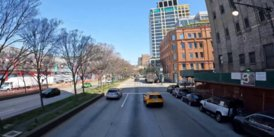
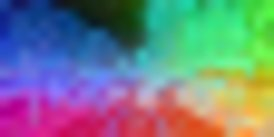
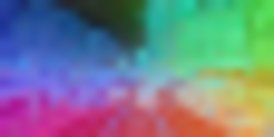
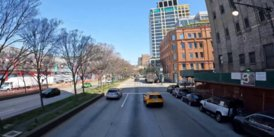
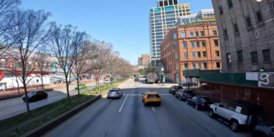
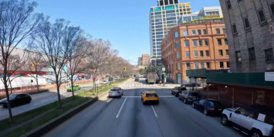
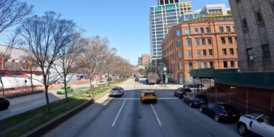
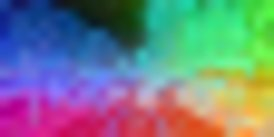
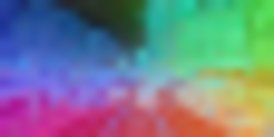
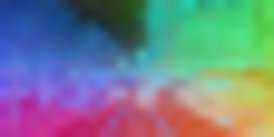
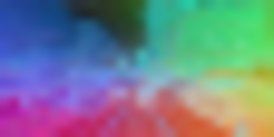
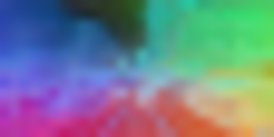
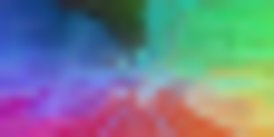
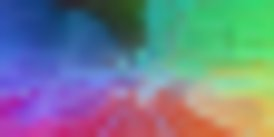
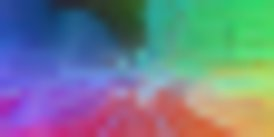
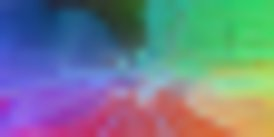

In [129]:
def fit_pca_from_feats(feats, n_components=3, max_samples=20000, seed=0):
    flat = feats.reshape(-1, feats.shape[-1]).float().cpu()
    if flat.shape[0] > max_samples:
        g = torch.Generator().manual_seed(seed)
        idx = torch.randperm(flat.shape[0], generator=g)[:max_samples]
        flat = flat[idx]
    mean = flat.mean(0, keepdim=True)
    centered = flat - mean
    _, _, vh = torch.linalg.svd(centered, full_matrices=False)
    components = vh[:n_components]
    proj = centered @ components.T
    minv = proj.min(0).values
    maxv = proj.max(0).values
    return mean.squeeze(0), components, minv, maxv


def pca_feats_to_rgb(feats, mean, components, minv, maxv):
    if feats.dim() == 4:
        feats = feats[0]
    h, w, c = feats.shape
    flat = feats.reshape(-1, c).float().cpu()
    proj = (flat - mean) @ components.T
    denom = (maxv - minv).clamp(min=1e-6)
    proj = (proj - minv) / denom
    proj = proj.clamp(0, 1)
    rgb = (proj.reshape(h, w, -1).numpy() * 255).astype(np.uint8)
    return Image.fromarray(rgb)


with torch.no_grad():
    ctx_feats = model.preprocess(frames).detach().cpu()

pca_mean, pca_components, pca_min, pca_max = fit_pca_from_feats(ctx_feats, n_components=3)

context_pca = [pca_feats_to_rgb(ctx_feats[:, -1], pca_mean, pca_components, pca_min, pca_max)]

pred_pca = []
for pred_feats in pred_feats_list:
    pred_pca.append(pca_feats_to_rgb(pred_feats, pca_mean, pca_components, pca_min, pca_max))

seeds = [0]
sample_pca = [pred_pca]

display_segm_grid(
    seeds=seeds,
    context_rgbs=context_rgbs,
    context_segs=context_pca,
    sample_segs=sample_pca,
    base_duration=90,
    scale=0.7,
    cell_width=args.img_size[1],
    cell_height=args.img_size[0],
    pred_label="Feat PCA",
    pred_is_mask=False,
)
